In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import scipy.optimize as spo
import scipy.stats as sts
plt.style.use('seaborn')

# Pressure Analysis from the Ground Up
This notebook follows all the steps of the pressure data analysis from `Data_Analysis.ipynb` as transparently and simply as possible. The notebook will be written in an order following the conceptual steps in the analysis, rather than separating plots and code.

## Data Import
Data is imported from an HDF5 file which is created from ASCII in the `Import_Data.ipynb` notebook. Code is in place for future datasets to be labeled with a date string.

In [2]:
run_label = '2020_11_09' ## Change this to look at different runs
hdf_name = '{}_clean_data.h5'.format(run_label)

The HDF5 file stores data for each of the five gases with the name of the gas as the key. This notebook imports each table by key into a list of `pandas` tables by order of molecular weight.

|Index|Gas           |
|-----|--------------|
|0    |Hydrogen      |
|1    |Water Vapor   |
|2    |Nitrogen      |
|3    |Oxygen        |
|4    |Carbon Dioxide|

In [3]:
gases = ['H2', 'H2O', 'N2', 'O2', 'CO2']
gas_tables = [] # appendable list of gas data tables from HDF5

for gas in gases:
    gas_tables.append(pd.read_hdf(hdf_name, key=gas))

Checking the CO2 table:

In [4]:
gas_tables[4]

,exp_time,pressure,ch1_lerp,ch2_lerp,mean_temp
1245126,0.0,7.660000e-07,293.5,293.4,293.45
3224153,41.0,7.640000e-07,293.5,293.4,293.45
2963520,83.0,7.720000e-07,293.5,293.4,293.45
748635,124.0,7.780000e-07,293.5,293.4,293.45
1839726,166.0,7.900000e-07,293.5,293.4,293.45
...,...,...,...,...,...
1775311,230590.0,1.390000e-08,293.6,293.5,293.55
2526489,230632.0,1.410000e-08,293.6,293.5,293.55
4378668,230673.0,1.420000e-08,293.6,293.5,293.55
419623,230715.0,1.400000e-08,293.6,293.5,293.55


## The Pressure Fitting Function
This is the fitting function for a single jump in temperature:
$$p(t,T) = A\cdot \exp\left(-\frac{b}{T}\right)\cdot\exp\left(-c\cdot t\cdot \exp\left(-\frac{b}{T}\right)\right)$$
In order to use `scipy.optimize.curve_fit` with this function, the values of $t$ and $T$ must be input as a numpy array of shape `(k, M)` where `k` is the number of predictors and `M` is the sample size. This is from the [curve_fit documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html).

In [5]:
def pressure_fit(tT, A, b, c):
    """Outputs the partial pressure for a given time (after the start of the temperature jump) and temperature.
    
    Arguments:
    tT: a (2,M) numpy array of time and temperature values, where M is the number of observations in the jump.
    A: the scaling parameter for the jump. Accounts for variables such as the initial concentration, etc.
    b: the activation energy (multiplied by k_B) in kelvins.
    c: the time constant which is proportional to the diffusion constant."""
    
    factor = np.exp(-1.0*b/tT[1])
    return A * factor * np.exp(-1.0*c*tT[0]*factor)

## Analysis of a Single Jump

### Finding the Jumps
For now, jumps are found manually by plotting the pressure vs. time for a gas and successively narrowing the time window until a single smooth curve is found. I've been using $CO_2$ as the gas of choice to find these jumps, but all the gases should give the same answers.

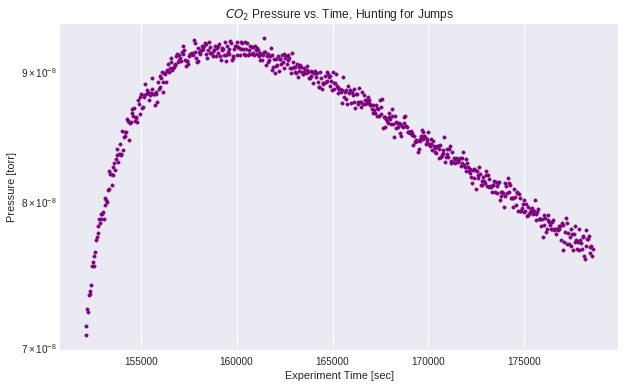

In [6]:
checked_bounds = [152100, 178600]
CO2_jump_table = gas_tables[4][gas_tables[4]['exp_time'].between(checked_bounds[0], checked_bounds[1])]

fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(CO2_jump_table['exp_time'], CO2_jump_table['pressure'], marker='.', color='purple')

ax.set_title('$CO_2$ Pressure vs. Time, Hunting for Jumps')
ax.set_xlabel('Experiment Time [sec]')
ax.set_ylabel('Pressure [torr]')
ax.set_yscale('log')

plt.show()

As the bounds of a given jump are found, place them into a nested list.

In [7]:
jump_bounds = [[51000, 64600], [64601, 90000], [90001, 110200], [110201, 152100], [152101, 178600]]

Note that since data is taken once every 41 or 42 seconds, double-counting data points would be very unlikely; however, just to be sure, I had each jump start "one second" after the previous one.

### Jump-Fitting Example: CO2 Jump 4
Jump 4 of the $CO_2$ pressure data has a long enough fall time to make it the best jump in the dataset to fit. We'll build up the analysis of it first and then generalize.

#### Extract Jump Data from Gas Table
We can use the `between` function from Pandas series to extract the experiment time, top temperature, and pressure from the jump.

In [8]:
CO2_jump4_table = gas_tables[4][gas_tables[4]['exp_time'].between(jump_bounds[3][0], jump_bounds[3][1])].reset_index(drop=True)
CO2_jump4_table

,exp_time,pressure,ch1_lerp,ch2_lerp,mean_temp
0,110219.0,9.610000e-08,319.7,321.90,320.800
1,110260.0,9.610000e-08,319.7,322.30,321.000
2,110302.0,9.540000e-08,319.8,322.90,321.350
3,110343.0,9.730000e-08,319.8,323.40,321.600
4,110385.0,9.700000e-08,319.8,324.10,321.950
...,...,...,...,...,...
1006,151918.0,7.130000e-08,328.3,331.00,329.650
1007,151959.0,6.990000e-08,328.3,331.00,329.650
1008,152001.0,7.110000e-08,328.3,331.25,329.775
1009,152042.0,7.020000e-08,328.4,331.60,330.000


We need the time to be shifted so that the first data point is the start time of the jump. We do this by finding the smallest value of `exp_time` and subtracting it.

In [9]:
CO2_jump4_table['exp_time'].min()

110219.0

In [10]:
CO2_jump4_table['jump_time'] = CO2_jump4_table['exp_time'] - CO2_jump4_table['exp_time'].min()
CO2_jump4_table

,exp_time,pressure,ch1_lerp,ch2_lerp,mean_temp,jump_time
0,110219.0,9.610000e-08,319.7,321.90,320.800,0.0
1,110260.0,9.610000e-08,319.7,322.30,321.000,41.0
2,110302.0,9.540000e-08,319.8,322.90,321.350,83.0
3,110343.0,9.730000e-08,319.8,323.40,321.600,124.0
4,110385.0,9.700000e-08,319.8,324.10,321.950,166.0
...,...,...,...,...,...,...
1006,151918.0,7.130000e-08,328.3,331.00,329.650,41699.0
1007,151959.0,6.990000e-08,328.3,331.00,329.650,41740.0
1008,152001.0,7.110000e-08,328.3,331.25,329.775,41782.0
1009,152042.0,7.020000e-08,328.4,331.60,330.000,41823.0


#### Getting the Pressure Fit Inputs
The fitting function will need the time and temperature data (`tT`) as a numpy array of shape `(2,M)` and the observed pressure data `press_obs` as a numpy array of shape `(M,)`.

In [11]:
CO2_jump4_tT = CO2_jump4_table[['jump_time', 'ch1_lerp']].T.to_numpy() # we're using the top temperature channel for now
CO2_jump4_press_obs = CO2_jump4_table['pressure'].to_numpy()

print('tT shape: {}\nPressure shape: {}'.format(CO2_jump4_tT.shape, CO2_jump4_press_obs.shape))

tT shape: (2, 1011)
Pressure shape: (1011,)


#### Optimization
We can now optimize over these inputs. The initial parameter guess will be based on previous fits.

In [12]:
init_params = [7, 1900, 0.005]

In [13]:
CO2_jump4_fit = spo.curve_fit(pressure_fit, CO2_jump4_tT, CO2_jump4_press_obs, p0=init_params, maxfev=100000)

In [14]:
CO2_jump4_fit[0]

array([6.57229840e-03, 3.55459365e+03, 7.68064073e-01])

#### Generate Predicted Values
We can calculate the pressure fits with a regular function call using the fit values.

In [15]:
CO2_jump4_pred = pressure_fit(CO2_jump4_tT, *CO2_jump4_fit[0])

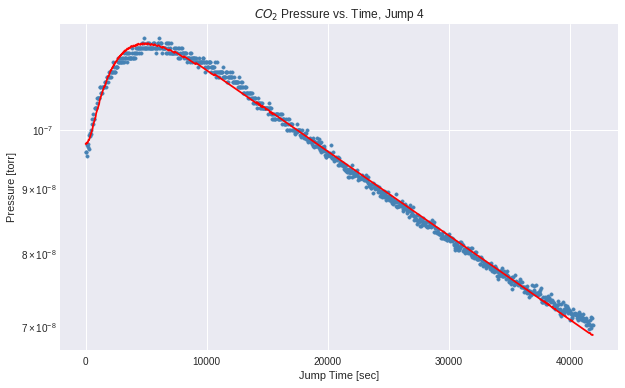

In [16]:
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(CO2_jump4_tT[0], CO2_jump4_press_obs, marker='.', color='steelblue')
ax.plot(CO2_jump4_tT[0], CO2_jump4_pred, color='red')

ax.set_title('$CO_2$ Pressure vs. Time, Jump 4')
ax.set_xlabel('Jump Time [sec]')
ax.set_ylabel('Pressure [torr]')
ax.set_yscale('log')

plt.show()

Here is the corresponding residual plot.

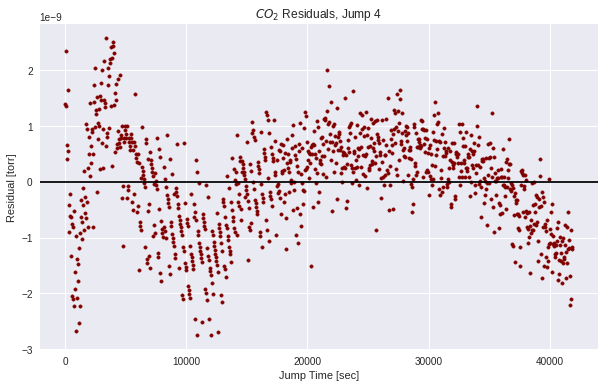

In [17]:
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(CO2_jump4_tT[0], CO2_jump4_pred-CO2_jump4_press_obs, marker='.', color='maroon')
ax.axhline(color='k')

ax.set_title('$CO_2$ Residuals, Jump 4')
ax.set_xlabel('Jump Time [sec]')
ax.set_ylabel('Residual [torr]')

plt.show()